In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import operator

from sklearn.metrics import r2_score, mean_squared_error, make_scorer

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import ElasticNetCV

# To install: conda install py-xgboost
import xgboost as xgb

In [11]:
# Adjust screen output size
#pd.util.terminal.get_terminal_size() # get current size
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)

### Dataset 5 with: original RGB data, categorized Google Places & Amenities Data,drop text processing 

In [6]:
data5 = pd.read_csv('data_test5.csv', index_col=0) 

In [7]:
# get train portion
train5 = data5[data5['dataset']=='train']

In [9]:
# drop id, dataset
train5 = train5.drop(['id', 'dataset'], axis=1)

In [22]:
# Split out predictors from target
y_data5 = train5['log_price']
x_data5 = train5.drop(['log_price'], axis=1)

In [23]:
# Split into training and test sets
x_train5, x_test5, y_train5, y_test5 = train_test_split(x_data5, y_data5, test_size=0.25, random_state=11)

##### Elastic Net

In [25]:
elasticNet5 = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

In [70]:
elasticNet5.fit(x_train5, y_train5)

ElasticNetCV(alphas=[0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
       copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
       max_iter=50000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [71]:
y_test_elas5 = elasticNet5.predict(x_test5)

In [72]:
# What is r2 score?
r2_score(y_test5, y_test_elas5)

0.6341793211732607

In [73]:
math.sqrt(mean_squared_error(y_test5, y_test_elas5))

0.43495102520968437

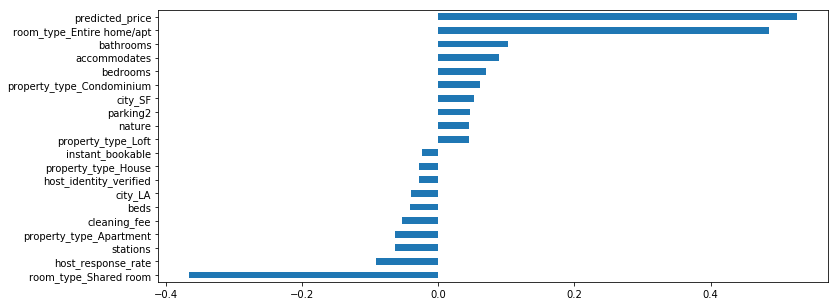

In [74]:
# What are the important coefficients?
plt.figure(figsize=(12,5))
coefs_elas = pd.Series(elasticNet5.coef_, index=x_train5.columns)
import_coefs_elas = pd.concat([coefs_elas.sort_values().head(10), coefs_elas.sort_values().tail(10)])
import_coefs_elas.plot(kind='barh')

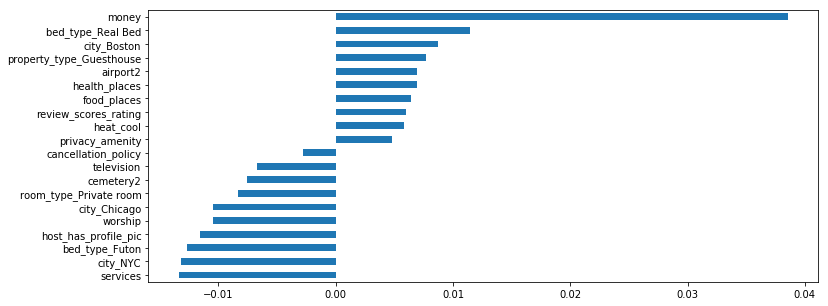

In [42]:
# What about the next 10 coefficients?
plt.figure(figsize=(12,5))
coefs_elas = pd.Series(elasticNet5.coef_, index=x_train5.columns)
import_coefs_elas = pd.concat([coefs_elas.sort_values()[10:20], coefs_elas.sort_values()[-20:-10]])
import_coefs_elas.plot(kind='barh')

In [75]:
# What were the dropped vars?
print("Elastic Net picked " + str(sum(coefs_elas != 0)) + " features and eliminated the other " +  \
      str(sum(coefs_elas == 0)) + " features")

Elastic Net picked 62 features and eliminated the other 11 features


In [76]:
# What were the features dropped
coefs_elas[coefs_elas==0]

wash                       0.0
internet_connect          -0.0
doorman_greet              0.0
parking_by_rental         -0.0
other_amenities            0.0
smoking_allowed            0.0
property_type_Other       -0.0
property_type_Other2      -0.0
property_type_Townhouse   -0.0
bed_type_Couch             0.0
bed_type_Pull-out Sofa     0.0
dtype: float64

In [49]:
# Distance Calc
coefs_elas.loc['distance_calc'] # In this case distance calc did not matter much

-0.0027008930827232022

In [51]:
# Colors - did not seem to matter much
coefs_elas.loc[['meanG', 'meanB', 'meanR']]

meanG    0.000350
meanB    0.000758
meanR   -0.000793
dtype: float64

##### Use XGBoost Regressor

In [54]:
dtrain = xgb.DMatrix(x_train5, y_train5)
dtest = xgb.DMatrix(x_test5)

xgb_params = {
    'eta': 0.037,
    'max_depth': 10,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': np.mean(y_train5),
    'silent': 0
}

In [55]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=242)

In [58]:
print('RMSE:', mean_squared_error(model.predict(dtrain), y_train5)**(1/2))

RMSE: 0.257534042464


In [64]:
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)

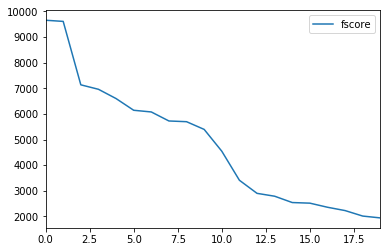

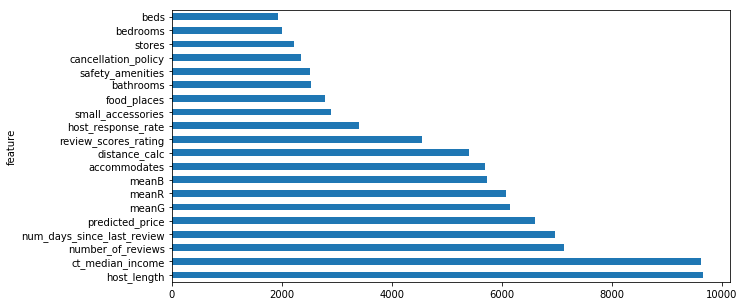

In [69]:
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
# plot top 100 features 
plt.figure()
df.head(20).plot()
df.head(20).plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 5))